# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

Machine learning is a technique that utilises mathematics and statistics to predict, forecast, or extrapolate something based on existing data using an automated piece of software. The application of machine learning could help businesses run their operations or make impactful decisions. If a person can add domain expertise, such as airline knowledge, to this problem, we could perform a data science task.

The problem will require machine learning, although machine learning alone will not be enough to understand the meaning of the data. The appropriate solution would be a data science solution since we will need to understand how the airline works and what could be the logical reasons a flight gets delayed. We can back our hypothesis with statistical analysis and plots and, finally, build a machine learning model to predict whether a future flight will be delayed.

Since the outcome of the solution must be a prediction of whether a flight will be delayed based on given data, a machine learning model will be an appropriate final product, although not the complete solution.

### 2. Formulate the business problem, success metrics, and desired ML output.

The business problem is practically described in the problem description, where we need to create a solution to predict whether a flight will be delayed based on the flight data. Knowing whether a flight will likely be delayed is vital for certain businesses. Consider a surgeon who needs to fly to a city within a specific window of time; otherwise, the patient might perish. Our service might be vital for the surgeon to pick a flight that is less likely to get delayed. Another example would be a high-ranking business person. If he needs to be somewhere for a meeting, the company must plan his journey accordingly; otherwise, he might be late for that meeting and lose millions of dollars. We could save the company money by giving them insight into which flight is less likely to get delayed.

In the businessman case, our feature is not very vital because if our model fails to oversight a delay, then the worst thing that can happen is that a company might lose some money. However, for some people, such as the surgeon, a failure to detect a flight delay might lead to a life-or-death situation. Therefore, although the feature is not vital for the majority of its application, there are some cases where our feature might be crucial. Because of those cases, we need to have high success metrics in an event where it is essential.

I would put the success metrics at 90% performance, a balance between accuracy, f1 score and AUC. Since the answer to the question is directed from a business perspective, I will not go into details about the performance metrics; otherwise, it will have too much jargon. We will see later in this document that the data is highly imbalanced, rendering accuracy useless without proper processing.

There are several ways we can set our machine learning output. We can have the output a binary output, which just says whether a flight will be delayed. Another output might be how long a flight might be delayed in minutes. However, this document will only deal with the binary output.

Finally, the output will be zero denoting whether a flight will not be delayed, and one where the flight is predicted to be delayed.

### 3. Identify the type of ML problem you’re dealing with.

In this document, we will give a solution model that takes input, process them in a pipeline, and then gives an output of either zero for non-delay or one for delayed. Although the output is in a numerical category, the target variable is categorical. Therefore, this machine learning problem is a classification problem.

This document will only deal with a classification problem, although in the future, we can turn it into a regression problem, to predict how long a flight will be delayed.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time
import datetime
from collections import defaultdict

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>

RANDOM_STATE = 0

# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [2]:
# download the files

# <note: make them all relative, absolute path is not accepted>
zip_path = 'data_compressed.zip'
base_path = ''
csv_base_path = 'data/'

try:
    os.mkdir(csv_base_path)
except:
    pass

In [3]:
# How many zip files do we have? write a code to answer it.
try:
    # Create empty list.
    zip_files = []
    
    # Get the filenames.
    with ZipFile(zip_path, mode='r') as zipfile:
        zip_info_list = zipfile.infolist()
        for zip_info in zip_info_list:
            zip_files.append(zip_info.filename)
    
    # Print for clarity.
    print(f'There are {len(zip_files)} zip files.')

except Exception as e:
    print(e)

There are 60 zip files.


#### Extract CSV files from ZIP files

In [4]:
def extract_zip(zip_filename, file_path):
    """
    Extract a zip file into another path.
    """
    
    try:
        with ZipFile(zip_filename, 'r') as zipfile:
            zipfile.extractall(path=file_path)
    except Exception as e:
        print(e)

def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

extract_zip(zip_path, '')

for file in zip_files:
    zip2csv(file, csv_base_path)

print("Files Extracted")

Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip 
Extracting data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip 
Extracting data_c

In [5]:
# How many csv files have we extracted? write a code to answer it.
def get_filenames(path, extension):
    """
    Get a list of filenames with an extension in a file.
    """
    filenames = []
    for file in os.listdir(path):
        if file.endswith('.' + extension):
            filenames.append(os.path.join(path, file))
    return filenames

# Get the list of filenames.
csv_filenames = get_filenames(csv_base_path, 'csv')

# Print for clarity.
print(f'{len(csv_filenames)} csv files were extracted.')

60 csv files were extracted.


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [6]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [7]:
print(csv_filenames[59])
df_temp = pd.read_csv(csv_filenames[59])

data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv


**Question**: Print the row and column length in the dataset, and print the column names.

In [8]:
df_shape = df_temp.shape
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [9]:
df_temp.head(10)

Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2018        3      9           3          1  2018-09-03                9E   
1  2018        3      9           9          7  2018-09-09                9E   
2  2018        3      9          10          1  2018-09-10                9E   
3  2018        3      9          13          4  2018-09-13                9E   
4  2018        3      9          14          5  2018-09-14                9E   
5  2018        3      9          16          7  2018-09-16                9E   
6  2018        3      9          17          1  2018-09-17                9E   
7  2018        3      9          20          4  2018-09-20                9E   
8  2018        3      9          21          5  2018-09-21                9E   
9  2018        3      9          23          7  2018-09-23                9E   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     20363                          9E      N908XJ  ...   
1                     20363                          9E      N315PQ  ...   
2                     20363                          9E      N582CA  ...   
3                     20363                          9E      N292PQ  ...   
4                     20363                          9E      N600LR  ...   
5                     20363                          9E      N316PQ  ...   
6                     20363                          9E      N916XJ  ...   
7                     20363                          9E      N371CA  ...   
8                     20363                          9E      N601LR  ...   
9                     20363                          9E      N906XJ  ...   

   Div4TailNum  Div5Airport  Div5AirportID  Div5AirportSeqID Div5WheelsOn  \
0          NaN          NaN            NaN               NaN          NaN   
1          NaN          NaN            NaN               NaN          NaN   
2          NaN          NaN            NaN               NaN          NaN   
3          NaN          NaN            NaN               NaN          NaN   
4          NaN          NaN            NaN               NaN          NaN   
5          NaN          NaN            NaN               NaN          NaN   
6          NaN          NaN            NaN               NaN          NaN   
7          NaN          NaN            NaN               NaN          NaN   
8          NaN          NaN            NaN               NaN          NaN   
9          NaN          NaN            NaN               NaN          NaN   

  Div5TotalGTime Div5LongestGTime  Div5WheelsOff Div5TailNum  Unnamed: 109  
0            NaN              NaN            NaN         NaN           NaN  
1            NaN              NaN            NaN         NaN           NaN  
2            NaN              NaN            NaN         NaN           NaN  
3            NaN              NaN            NaN         NaN           NaN  
4            NaN              NaN            NaN         NaN           NaN  
5            NaN              NaN            NaN         NaN           NaN  
6            NaN              NaN            NaN         NaN           NaN  
7            NaN              NaN            NaN         NaN           NaN  
8            NaN              NaN            NaN         NaN           NaN  
9            NaN              NaN            NaN         NaN           NaN  

[10 rows x 110 columns]

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [10]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [11]:
# Enter your code here
for col in df_temp.columns:
    if 'Del' in col:
        print(col)

DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
DivArrDelay


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [12]:
# to answer above questions, complete the following code
print("The #rows and #columns are", df_temp.shape[0] , "and", df_temp.shape[1])
print("The years in this dataset are:", df_temp['Year'].unique())
print("The months covered in this dataset are:", df_temp['Month'].unique())
print("The date range for data is:" , min(df_temp['FlightDate']), "to", max(df_temp['FlightDate']))
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))

The #rows and #columns are 585749 and 110
The years in this dataset are: [2018]
The months covered in this dataset are: [9]
The date range for data is: 2018-09-01 to 2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ', 'MLI'

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [13]:
counts = pd.DataFrame({'Origin':df_temp['Origin'].value_counts(), 'Destination':df_temp['Dest'].value_counts()})
counts

Origin  Destination
ABE     303          303
ABI     169          169
ABQ    2077         2076
ABR      60           60
ABY      79           79
..      ...          ...
WRG      60           60
WYS      52           52
XNA    1004         1004
YAK      60           60
YUM      96           96

[346 rows x 2 columns]

**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [14]:
counts.sort_values(by=['Origin', 'Destination'],ascending=False).head(15 )# Enter your code here

Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877

**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

It is premature to tell whether the information in the CSV file will be sufficient to predict whether a flight will be delayed statistically. We need more information regarding the correlation of each data to the target column. In this scenario, our target is a binary classification; thus, ANOVA might be enough to test the numerical columns and whether there is a correlation between those columns with the target. The Chi-square test will be good to know whether there is independence or dependence on each categorical column to the target.

However, knowing the correlation between all columns and the target might not be enough to predict whether the data will be a good enough indication to predict the target. There are leverage and influential points where the data seems normal when we analyse them independently; however, the data points seem to defy the other combinations as a row combination. If we have many influential points, there is a good indication that the data has no reasonable explanation for the target.

In conclusion, we need to move forward and make a machine-learning model to answer the question. If the performance of the machine learning is satisfactory, then yes, we can predict a flight will be delayed, given all the information. In contrast, if the model performance does not reach the requirement, then the information will not be enough or relevant to predict whether a flight will be delayed.

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [15]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    final_data = defaultdict(list)
    for csv_filename in csv_files:
        df_temp = pd.read_csv(csv_filename)
        df_temp = df_temp[filter_cols]
        for subset_col, subset_val in zip(subset_cols, subset_vals):
            df_temp = df_temp[df_temp[subset_col].isin(subset_val)]
        for col in df_temp.columns:
            final_data[col] = final_data[col] + df_temp[col].tolist()
    df_final = pd.DataFrame(data=final_data)
    try:
        df_final.to_csv(file_name, index=False)
    except Exception as e:
        print(e)
    return df_final

In [16]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [17]:
start = time.time()

combined_csv_filename = f"{base_path}combined_files.csv"

combine_csv(csv_filenames, cols, subset_cols, subset_vals, combined_csv_filename)

print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

csv's merged in 2.32 minutes


#### Load dataset

Load the combined dataset.

In [18]:
data = pd.read_csv(combined_csv_filename)# Enter your code here to read the combined csv file.

Print the first 5 records.

In [19]:
# Enter your code here 
data.head(5)

Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX        2145        0.0       0.0   
1    DFW          TX  ATL        GA         945        0.0       0.0   
2    ATL          GA  DEN        CO        1855        0.0       0.0   
3    ATL          GA  PHX        AZ        1634        0.0       0.0   
4    PHX          AZ  ATL        GA         700        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  ArrDel15  AirTime  
0     689.0              3     -20.0              0.0       0.0     99.0  
1     731.0              3      -3.0              0.0       0.0     98.0  
2    1199.0              5      -7.0              0.0       0.0    174.0  
3    1587.0              7      -4.0              0.0       0.0    233.0  
4    1587.0              7     -13.0              0.0       0.0    179.0

Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [20]:
# to answer above questions, complete the following code
print("The #rows and #columns are", data.shape[0] , "and", data.shape[1])
print("The years in this dataset are:", data['Year'].unique())
print("The months covered in this dataset are:", data['Month'].unique())
print("The date range for data is:" , min(data['FlightDate']), "to", max(data['FlightDate']))
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))

The #rows and #columns are 1658130 and 20
The years in this dataset are: [2014 2015 2016 2017 2018]
The months covered in this dataset are: [ 1 10 11 12  2  3  4  5  6  7  8  9]
The date range for data is: 2014-01-01 to 2018-12-31
The airlines covered in this dataset are:  ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are:  ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are:  ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [21]:
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True) # Enter your code here

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [22]:
# Enter your code here
data.isnull().sum(axis=0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64

The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [23]:
### Remove null columns
# Did you mean remove null rows?
# Otherwise we are removing the target column.
data = data.dropna()

Get the hour of the day in 24-hour time format from CRSDepTime.

In [24]:
data['DepHourofDay'] = [int(str(dep_time)[:2]) if len(str(dep_time)) == 4 else int(str(dep_time)[:1]) for dep_time in data['CRSDepTime']]

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

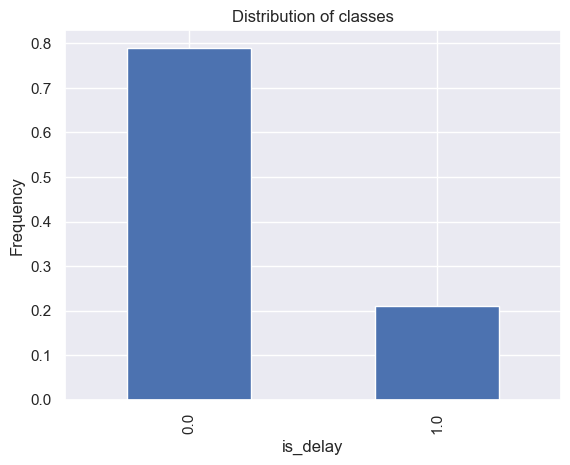

In [25]:
(data.groupby(['is_delay']).size()/len(data) ).plot(kind='bar')# Enter your code here
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

The above bar plot suggests a decisive imbalance in the target column. Around 79% of the data points belong to the not-delayed, while 21% belong to the delayed class. The almost 1:4 ratio might be problematic for the future classifier since the model will be highly biased towards the majority class while not getting enough insight into the minority class.

Based on this insight, if the imbalanced nature of the data is left untreated, our classifier will have a more challenging time classifying a data point as the minority class, in this case, the 'delayed' class. Therefore, we will focus on looking at the future models' precision, recall and f1 score to monitor how the imbalanced data affect the performance.

If my concerns were valid, then the positive class recall or sensitivity would be severely low, while barely any f1 score for the minority class. That is why it is essential to look at the precision, recall (sensitivity and specificity), and f1 scores instead just at the accuracy.

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

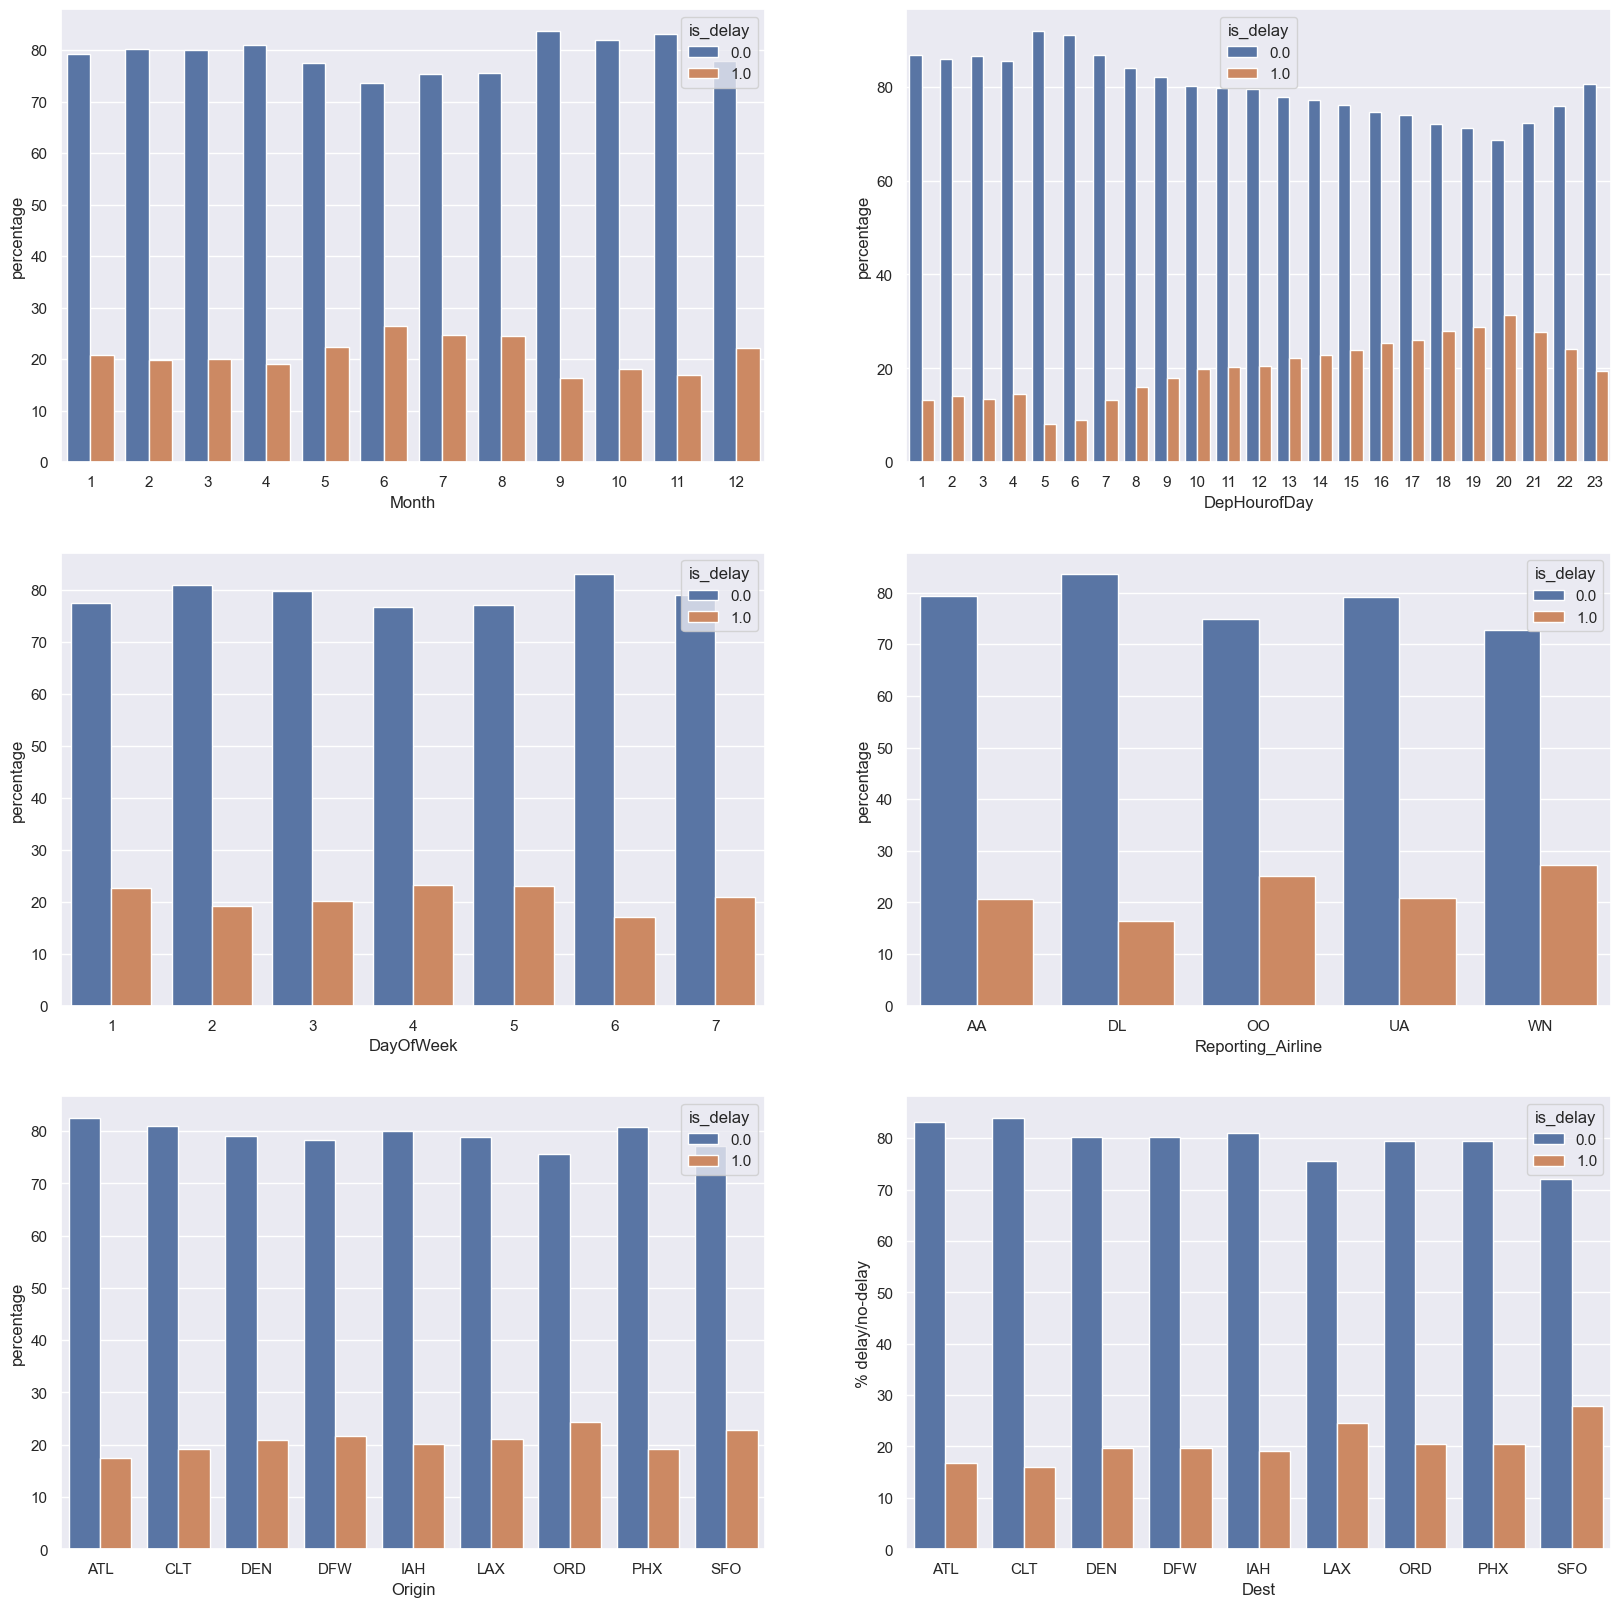

In [26]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

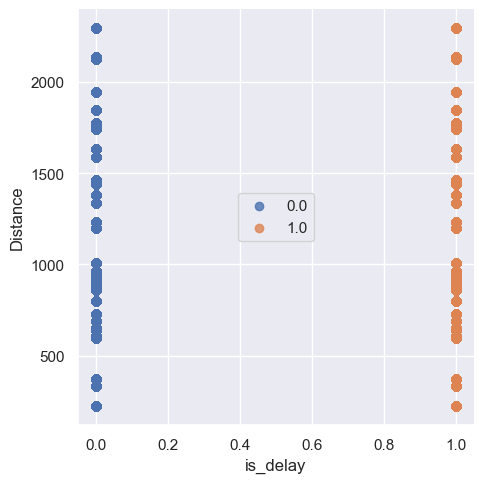

In [27]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

### Questions

#### Which months have the most delays?
June

#### What time of the day has the most delays?
8 PM

#### What day of the week has the most delays?
Thursday

#### Which airline has the most delays?
Southwest Airlines (WN)

#### Which origin and destination airports have the most delays?
Origin - Chicago's O'hare International Airport (ORD)
Destination - San Francisco International Airport (SFO)

#### Is flight distance a factor in the delays?
No

### Data Analysis

#### Introduction - Data Explanation
Even though there are a couple of exceptions, the bar for each category in every graph looks very similar. We will go through each graph one by one to get more insight, but it is important to note that in every graph, 'non-delayed' outnumbered 'delayed' by a considerable ratio.

#### Delayed for each Month
The data shows that June, July, and August are the top three months where flight delays are the most frequent. The top months are expected since, in the US, those months are the times for school holidays, when families usually book flights to go for a holiday. With more people per flight, there is a higher chance for something to happen that causes delays, such as a longer boarding process and late passengers. If we apply that logic, December and January should have a higher delay rate. It is true that December and January get the fourth and fifth spots. Most Americans will celebrate Christmas in their hometown, which is why delays are more frequent during Christmas. In some places, winter snow might affect the delays, thus adding to the delay count.

On the other hand, September has the lowest number of delayed flights. Since most people are finished with their holiday at that time, usually only frequent fliers, such as people with business trips, use the flight services. Frequent fliers are typically accustomed to the airport processes, which make flights more efficient during boarding processes.

#### Delayed for each Hour of the Day
We can see a trend in the delayed count over the hour, where the lowest count is at 5 AM and then continuously increases until 8 PM. The trend is expected, considering how an airline utilises an aircraft for its service. Consider a daily schedule for one aircraft. Usually, the typical day for an aircraft starts at either the parking strips of an airport, a hangar, or directly parked at the gate near the taxiway. If the first flight is at 5 AM, the pilot just brings the aircraft to the gate, and passengers can simply board the plane. After that plane is boarded, it can continue to take off and fly to the next airport. Once it gets to the next airport, that arrival airport becomes the departure airport for the next flight. The design becomes a problem when the aircraft does not arrive at the next airport on time, which typically causes a delay. There are some causes that make an aircraft arrive late, such as congested runway at the previous airport, bad weather, and long boarding process. Let us consider an aircraft that arrive on time for the first flight while arriving late on the second flight for the day. The departure time will likely be delayed for subsequent flights after that second flight. Therefore, as the day progresses, more and more aircraft get delayed.

#### Delayed for each Day of the Week
This explanation assumes that 1-7 refers to Monday to Sunday.

Saturday has the lowest 'delay' rate, while Thursday has the highest ' delay rate. Thursdays and Fridays have the highest rate of flight delays. There are a few possible reasons, one of them is since it is close to the weekend, there is more workload for business people, thus a higher chance for those people to either be late or miss a flight. Tuesdays and Saturdays are the best time to take a flight since the delay rate is lower than the rest of the week.

#### Delayed per Airline
Southwest Airlines has the highest delay percentage, with a 28% of flights delayed, considering the total average delay is around 21%. On the other hand, Delta Airlines has the lowest delay percentage, with only 17% of the flights being delayed. Other airlines are closer to the general mean.

#### Delayed per Origin Airport
Chicago's O'hare International Airport has the highest delay percentage on our list, with 25% of the flights departing from that airport getting delayed. That means 1 in 4 flights departing from that airport will be delayed at least 15 minutes. On the other hand, Hartsfield Jackson Atlanta International Airport has the lowest delay percentage of 18%. Take note of the San Francisco International Airport delayed rate of 22% for the next section.

#### Delayed per Destination Airport
There is some destination airport that has a higher chance of getting delayed. For example, if you go to San Francisco International Airport, you have a 29% chance of getting delayed. The following airport we might want to avoid is the Los Angeles International airport, with a 25% chance the flight might get delayed. The high number of delays in the category might impact the number of delays in the previous graph because, as we established before if an aircraft reaches its destination late, the subsequent flight it has that day will likely be delayed. Therefore, it is good that the San Francisco International Airport managed to suppress that number of 29% late arrival to only 22% delayed departures. Chicago's O'hare International Airport has the worst efficiency, getting only 20% late arrival and converting that to 25% in departures.

#### Delayed per Distance
There is no defining difference between 'delayed' and 'non-delayed' flights in terms of destination since the points of the two classes are the same.

#### Conclusion
We can see some patterns to determine whether a flight will be delayed, such as what time of the day it is and which airport the aircraft departs from. However, the ratio of 'non-delayed' and 'delayed' is still very imbalanced for the statistical model; thus, in every scenario, you are likely to get a 'non-delayed' flight, although we can minimize those numbers by looking at the statistics in this graph.

### Features

Look at all the columns and what their specific types are.

In [28]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [29]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [30]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('object')# Enter your code here

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [31]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data, data_dummies], axis=1)
data.drop(categorical_columns,axis=1, inplace=True)

Check the length of the dataset and the new columnms.

In [32]:
# Enter your code here
print(f'Number of rows: {data.shape[0]}')
print(f'Number of columns: {data.shape[1]}')

Number of rows: 1635590
Number of columns: 94


In [33]:
# Enter your code here
data.columns

Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN',

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [34]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here

In [35]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# note this combined file will be used in part B
data.to_csv(f'{base_path}combined_csv_v1.csv', index=False)

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [36]:
# write Code here to split data into train, validate and test
X = data.drop(['target'], axis=1).to_numpy()
y = data['target'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

### Baseline classification model

In [37]:
# <write code here>
baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)

LogisticRegression()

## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [38]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted, labels=['Non-delayed', 'Delayed'], title='Confusion Matrix'):
    # complete the code here
    # Create confusion matrix.
    cm = confusion_matrix(test_labels, target_predicted)
    # Plot heatmap.
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.4%', cmap='Blues', xticklabels=labels, yticklabels=labels)
    # Set labels.
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [39]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted, title='AUC-ROC'):
    # complete the code here
    display = metrics.RocCurveDisplay.from_predictions(test_labels, target_predicted)
    plt.title(title)
    plt.show()

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

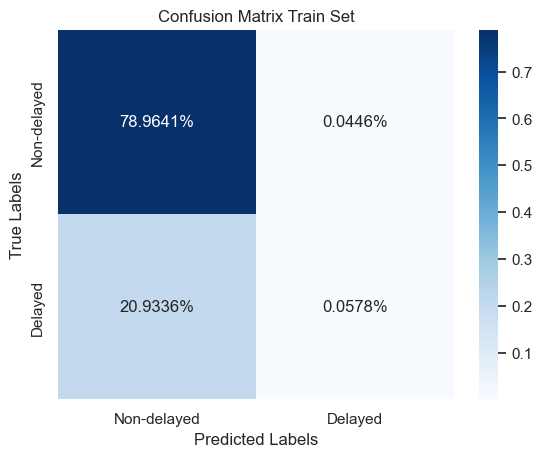

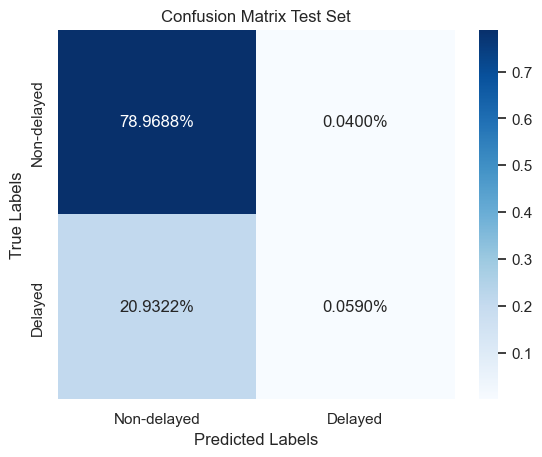

In [40]:
# Enter you code here
target_predicted = baseline_model.predict(X_test)

plot_confusion_matrix(y_train, baseline_model.predict(X_train), title='Confusion Matrix Train Set')
plot_confusion_matrix(y_test, target_predicted, title='Confusion Matrix Test Set')

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

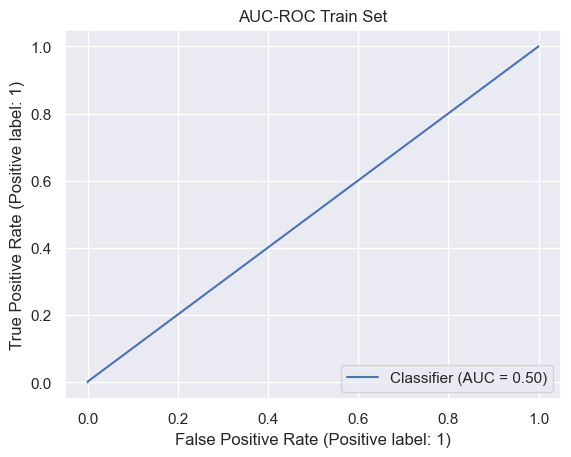

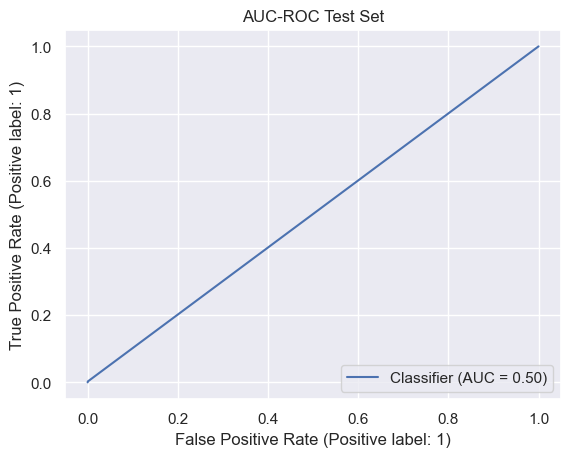

In [41]:
# Enter you code here
plot_roc(y_train, baseline_model.predict(X_train), title='AUC-ROC Train Set')
plot_roc(y_test, target_predicted, title='AUC-ROC Test Set')

In [42]:
# Accuracies, precision, recall, f1 score.
def result_summary(test_labels, target_predicted, header=None):
    if (header is not None):
        print(f'{str(header)}')
        print('=' * 20)
    accuracy = metrics.accuracy_score(test_labels, target_predicted)
    f1_score = metrics.f1_score(test_labels, target_predicted)
    print(f'Accuracy: {accuracy}')
    print(f'f1 score: {f1_score}')
    print(metrics.classification_report(test_labels, target_predicted))

result_summary(y_train, baseline_model.predict(X_train), 'Train Set')
result_summary(y_test, target_predicted, 'Test Set')

Train Set
Accuracy: 0.7902186672699149
f1 score: 0.005478161627506749
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88   1033806
         1.0       0.56      0.00      0.01    274666

    accuracy                           0.79   1308472
   macro avg       0.68      0.50      0.44   1308472
weighted avg       0.74      0.79      0.70   1308472

Test Set
Accuracy: 0.790277514536039
f1 score: 0.00559501377011161
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    258452
         1.0       0.60      0.00      0.01     68666

    accuracy                           0.79    327118
   macro avg       0.69      0.50      0.44    327118
weighted avg       0.75      0.79      0.70    327118



### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


#### How does your model's performance on the test set compare to the training set? What can you deduce from this comparison?
Looking briefly, there is no difference in performance when evaluated on training and test set. Therefore, we can deduce no discrepancies between the training and the test set when splitting the data. I ensured that the ratio was maintained by passing the stratify parameter in the scikit learn train-test-split function.

#### Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences?
For this analysis, I will focus on the test set.

There are apparent differences between the accuracy, precision, recall, and the f1 score. While the accuracy is at 0.79, the f1 score (the harmonic value between precision and recall) is at 0.006. The disparity between the two values is caused by the data imbalance between the positive and negative classes. As we mentioned, there is a 1:4 ratio between zero ('non-delayed') and one ('delayed'). Let us take a look at precision and recall. Precision is the true positives divided by the model's total number of positive predictions. Since the model rarely predicts any data point as 'delayed', we have a reasonable positive class precision of 0.6. Recall in the positive class is known as sensitivity, where the true positive is divided by the total number of positives in the data. Amongst the 'delayed' data, 99.997% were identified as 'non-delayed' while only 0.003% that is correctly identified. We can observe that the recall of the positive class is 0, which reflects the 'delayed' data result. Therefore, the f1 score is at 0.01 for the positive class, which is objectively low.

The imbalance affects accuracy because the majority of the class is negative. If we classified everything as negative, the accuracy would be 0.79, which is just the ratio of the positive and negative classes we saw in the previous analysis, a 21-79 split between 'delayed' and 'non-delayed'.

Because the dataset's accuracy is unreliable, we observe the precision, recall, and f1 score. We know that the model is biased towards the negative class, where it rarely classifies anything as the positive class.

#### Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)?

I deemed that the f1 score has the most justification for the model since it is only one number that takes every precision and recall into account. However, the f1 score for our model is 0.006, which is not even near what we have set as the target at the beginning of the document. The model we just made is not appropriate to be released as a working product because it would classify everything as 'non-delayed'.

Since we know the problem is the imbalance between the model, I would address that first. Several sampling methods could solve the imbalance problem, mainly under-sampling or over-sampling. Under-sampling means bringing the majority class count on level terms with the minority class, while over-sampling means that we produce more minority class to match the number of the majority class. There are some methods for each sampling category, such as Near Miss for under-sampling or SMOTE for over-sampling.

#### What can you summarize from the confusion matrix?
The confusion matrix is presented with the percentage of the data compared to the whole dataset. Remember that 79% belong to the negative class while 21% belong to the positive class.

Almost all 'non-delayed' were correctly identified, with almost 78.97% true positives for the negative class. The rest, 0.04%, were identified as 'delayed' by the model, giving a negative class recall, or specificity, of almost 100%. Out of 21% of 'delayed' data points, 20.932% were classified as 'non-delayed' by the model. Because of the result, the precision of the negative class is 0.79, which is higher than expected; however, the number of the negative class support is substantially higher than the positive class support. The rest 0.06% of the 'delayed' class is correctly classified. As we can see from the positive class precision, even those classified as 'delayed' has only a 0.6 possibility that it is delayed in the actual label.

The model has poor performance.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


https://gitlab.com/calvinjoseph/datascienceandtechnologiesfinalproject

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [43]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = [int(1) if date in holidays else int(0) for date in data_orig['FlightDate']]

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [44]:
# download data from the link above and place it into the data folder
df_weather = pd.read_csv('https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31')
df_weather.to_csv(f'{csv_base_path}daily-summaries.csv', index=False)

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [45]:
weather = pd.read_csv(f'{csv_base_path}daily-summaries.csv') # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = dict(zip(station, airports))
weather['airport'] = weather['STATION'].map(station_map)

In [46]:
weather.head()

STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport  
0     LAX  
1     LAX  
2     LAX  
3     LAX  
4     LAX

Create another column called `MONTH` from the `DATE` column.

In [47]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport MONTH  
0     LAX    01  
1     LAX    01  
2     LAX    01  
3     LAX    01  
4     LAX    01

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [48]:
weather.SNOW.fillna(0, inplace=True)# Enter your code here
weather.SNWD.fillna(0, inplace=True)# Enter your code here
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [49]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = np.array(list(weather['TAVG'].index[weather['TAVG'].apply(np.isnan)]))
TMAX_idx = np.array(list(weather['TMAX'].index[weather['TMAX'].apply(np.isnan)]))
TMIN_idx = np.array(list(weather['TMIN'].index[weather['TMIN'].apply(np.isnan)]))
TAVG_idx

array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [50]:
weather_impute = weather.groupby(['MONTH','STATION']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

MONTH      STATION       TAVG        TMAX       TMIN
0    01  USW00003017  -2.741935   74.000000 -69.858065
1    01  USW00003927  79.529032  143.767742  20.696774

Merge the mean data with the weather data.

In [51]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [52]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [53]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [54]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [55]:
sum(data.isna().any())

0

In [56]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [57]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('object')

In [58]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [59]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [60]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here

In [61]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B
data.to_csv(f'{base_path}combined_csv_v2.csv', index=False)

Create the training and testing sets again.

In [62]:
# Enter your code here
X = data.drop(['target'], axis=1).to_numpy()
y = data['target'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [63]:
# Instantiate another logistic regression model
classifier2 = LogisticRegression()
classifier2.fit(X_train, y_train)
target_predicted = classifier2.predict(X_test)

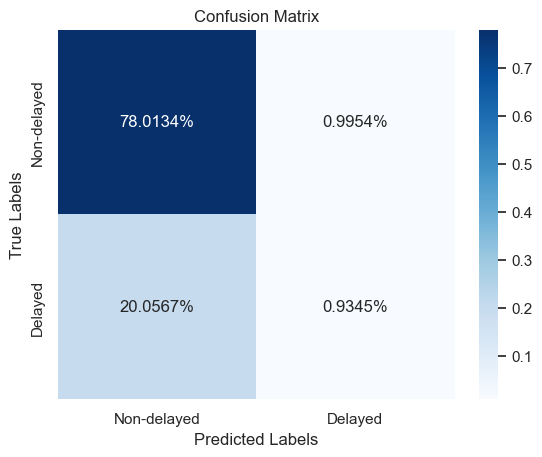

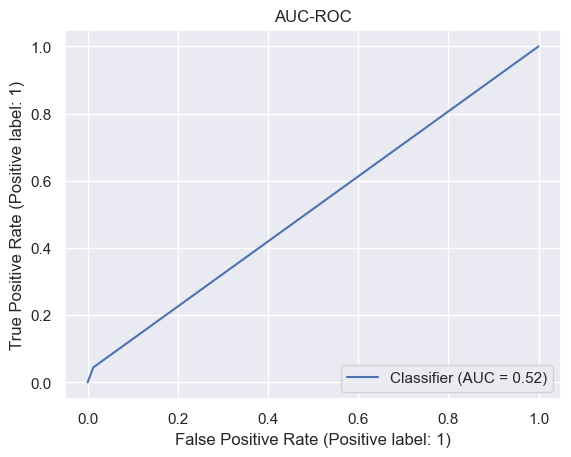

Accuracy: 0.7894796373174207
f1 score: 0.08154283199295802
              precision    recall  f1-score   support

         0.0       0.80      0.99      0.88    258452
         1.0       0.48      0.04      0.08     68666

    accuracy                           0.79    327118
   macro avg       0.64      0.52      0.48    327118
weighted avg       0.73      0.79      0.71    327118



In [64]:
# Enter your code here
plot_confusion_matrix(y_test, target_predicted)
plot_roc(y_test, target_predicted)
result_summary(y_test, target_predicted)

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

Since we already established no significant difference between the training and testing set, we will focus on the test set analysis. We also demonstrate that accuracy does not represent the model's actual performance; we will ignore accuracy for the explanation below.

There are minor noticeable improvements by adding extra data. We consider whether a flight is flying during holidays, which is insightful considering that the number of people will affect the flight schedule. We also added the weather data because, logically, bad weather could cause flight delays.

In the first classifier, the f1 score was 0.005, while now it is at 0.082. The results suggest that the second model has some positive effect on suppressing the bias towards the model and generally is a better predictor. We can see that the sensitivity rose from 0 to 0.04, which supports the argument that the model is somewhat trying to predict a 'delayed' class. However, we need to look at the positive class's precision. It is at 0.48, whereas before, it was 0.6. The data suggest that if the model predicts a data point to be 'delayed', it has 0.48 confidence that the flight will be delayed, and the precision is less than 0.5. Therefore, in other words, the model is classifying 'delayed' flights at random since there is no confidence whether the flights that are classified as 'delayed' is actually 'delayed' or 'non-delayed'. Finally, we need to consider the number of negative classes present in the dataset, which could contribute to the low precision in the positive class.

Because the precision is less than 0.5, we can conclude that although the f1 score is higher than the first model, adding the extra data does not help predict whether a flight will be delayed because of the precision score.

I put on some more testing below to address the imbalance and perform a PCA transformation. However, there is no improvement in the positive precision; thus, none of the models below will be appropriate for business deployment.

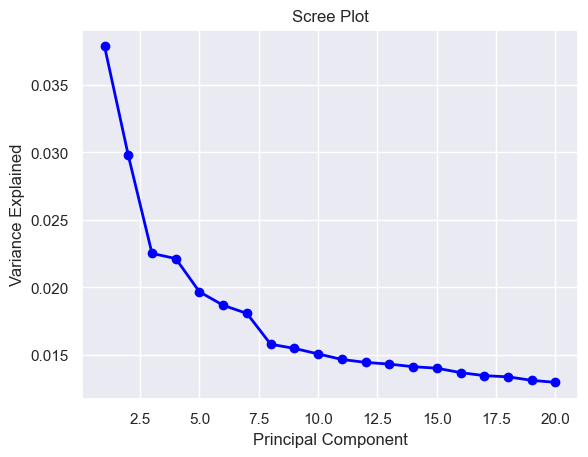

In [65]:
# Find PCA components
scaler = StandardScaler()
X_standardised = scaler.fit_transform(X)

pca = PCA(n_components=20)

def scree_plot(X, n_components=20):
    pca = PCA(n_components=n_components)
    pca_fit = pca.fit(X)
    PC_values = np.arange(pca.n_components) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.show()

scree_plot(X_standardised, 20)

In [66]:
# Redo training, with standardized and PCA.
scaler = StandardScaler()
pca = PCA(n_components=8)
X_standardised = scaler.fit_transform(X)
X_PCA = pca.fit_transform(X_standardised)

# Train, test split.
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

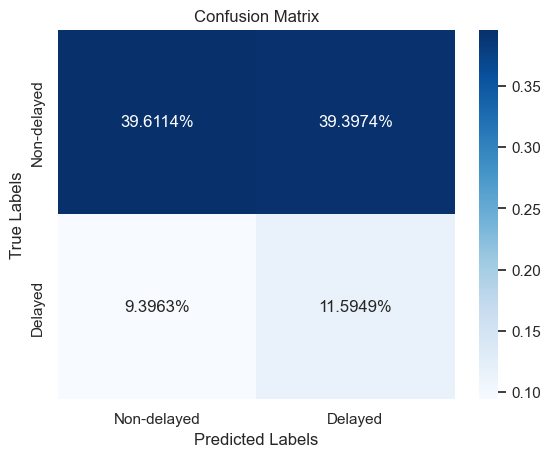

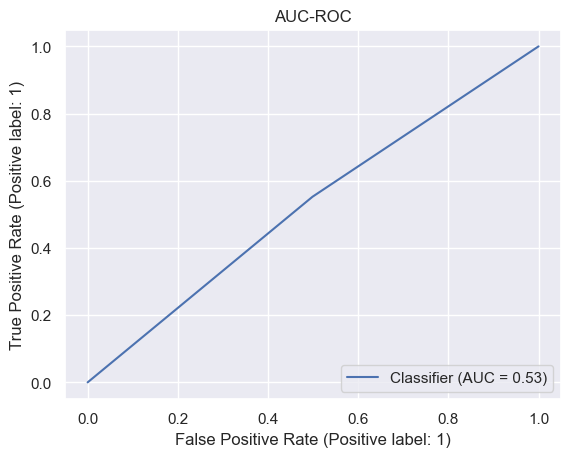

Accuracy: 0.5120629253052416
f1 score: 0.322154320489572
              precision    recall  f1-score   support

         0.0       0.81      0.50      0.62    258452
         1.0       0.23      0.55      0.32     68666

    accuracy                           0.51    327118
   macro avg       0.52      0.53      0.47    327118
weighted avg       0.69      0.51      0.56    327118



In [67]:
# Redo training, with SMOTE over-sampling.
over_sampler = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)

# Fit model.
classifier3 = LogisticRegression()
classifier3.fit(X_train, y_train)
target_predicted = classifier3.predict(X_test)

# Get performance results.
plot_confusion_matrix(y_test, target_predicted)
plot_roc(y_test, target_predicted)
result_summary(y_test, target_predicted)

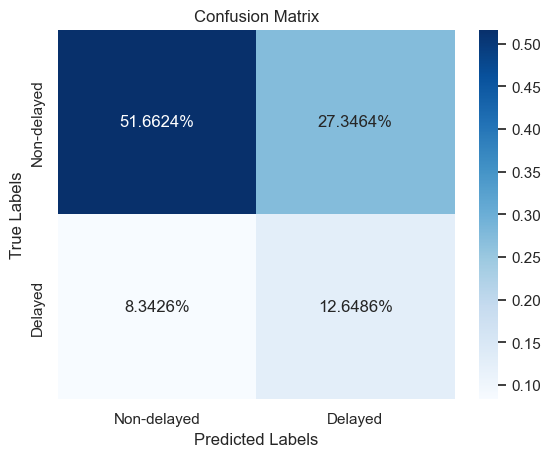

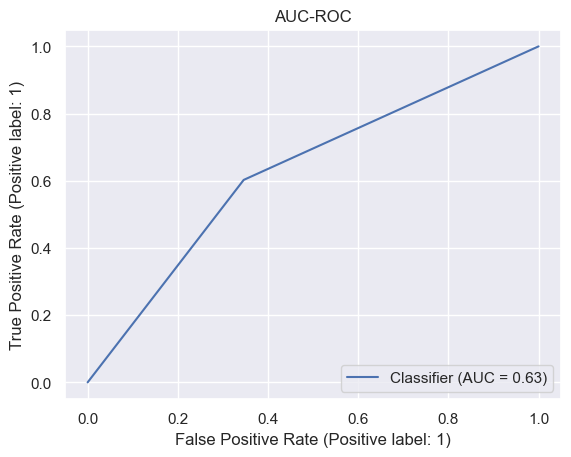

Accuracy: 0.6431104372122598
f1 score: 0.4148032301237613
              precision    recall  f1-score   support

         0.0       0.86      0.65      0.74    258452
         1.0       0.32      0.60      0.41     68666

    accuracy                           0.64    327118
   macro avg       0.59      0.63      0.58    327118
weighted avg       0.75      0.64      0.67    327118



In [68]:
# I found that not using PCA is better.

# Train, test split.
X_train, X_test, y_train, y_test = train_test_split(X_standardised, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# SMOTE over-sampling.
over_sampler = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)

# Fit model.
classifier4 = LogisticRegression()
classifier4.fit(X_train, y_train)
target_predicted = classifier4.predict(X_test)

# Get performance results.
plot_confusion_matrix(y_test, target_predicted)
plot_roc(y_test, target_predicted)
result_summary(y_test, target_predicted)

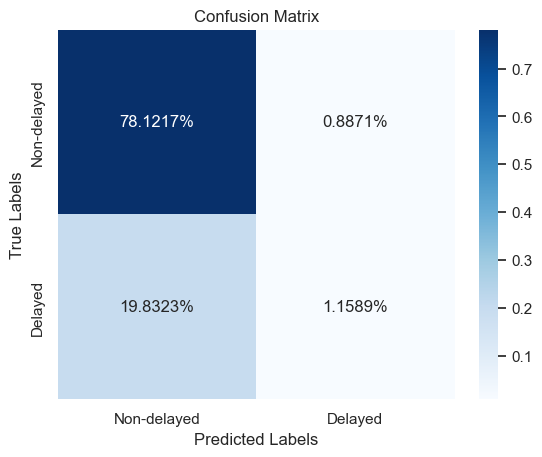

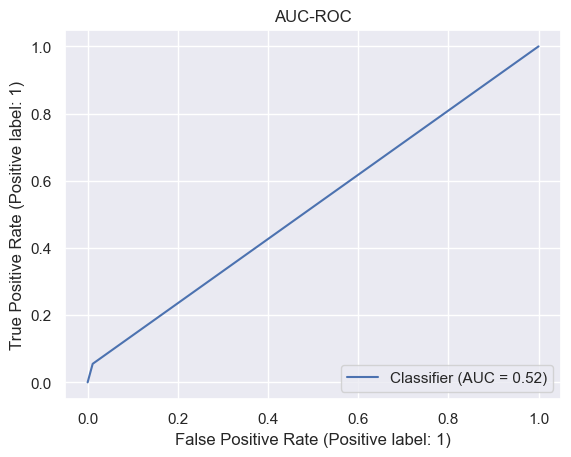

Accuracy: 0.7928056542287493
f1 score: 0.100611738478483
              precision    recall  f1-score   support

         0.0       0.80      0.99      0.88    258452
         1.0       0.57      0.06      0.10     68666

    accuracy                           0.79    327118
   macro avg       0.68      0.52      0.49    327118
weighted avg       0.75      0.79      0.72    327118



In [69]:
# Without the over sampler, the data precision is higher but the f1 score decreases to 0.1.

# Train, test split.
X_train, X_test, y_train, y_test = train_test_split(X_standardised, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# SMOTE over-sampling.
# over_sampler = SMOTE(random_state=RANDOM_STATE)
# X_train, y_train = over_sampler.fit_resample(X_train, y_train)

# Fit model.
classifier5 = LogisticRegression()
classifier5.fit(X_train, y_train)
target_predicted = classifier5.predict(X_test)

# Get performance results.
plot_confusion_matrix(y_test, target_predicted)
plot_roc(y_test, target_predicted)
result_summary(y_test, target_predicted)

# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

Tableau: https://public.tableau.com/views/final_project_16672869431020/FinalDashboard?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

#### Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
In the beginning, we set up our goal to be able to explain 90% of whether a flight will be delayed or not. However, looking at the models, we have no models that have fulfilled the business requirements. Therefore, the models that we have does not meet our business goal.

Looking at the end of the data, there are a couple of things that we can try. Firstly, we could perform a feature selection instead of feature reduction or PCA. I would start feature selection by ranking each feature with the correlation to the target. The top of the list should be the feature with the strongest correlation to the target. There are some statistical metrics to find the correlation's strength, such as ANOVA. Then I would train the model with just the top feature, essentially one feature for the model. After that, I would train another model but add the next feature. If we store all results in a list, such as the f1 score, we should have a list of f1 scores, that is, the number of features we have. If we plot them, we should be able to determine how many features are needed for our model.

Secondly, based on our results, there is a good indication that our data does not produce a reasonable explanation or discrimination to determine whether a flight has been delayed or not. We have tried using SMOTE over-sampling to deal with the imbalance; however, we found another problem with the model. Therefore, the problem might be the data itself; either the information is insufficient to determine a delay, or there is no pattern on what makes a delay with prior information. Because of the problem presented in this document, we need to find more data or different data to construct our predictor. We could start by talking to a professional in airline management, getting insight into what factors usually lead to delays. After further research, we might be able to know what kind of data we need to create a better model that predicts flight delays.

If it is possible, there is a chance that we could change the business requirements. We could take advantage of that in binary logistic regression; the model returns a probability rather than a definite answer. Our output could be several how likely a flight could be delayed instead of a complete decision.

Finally, we only tried logistic regression in this project. We could fit our data into other models, such as Naive Bayes, SVM, and ensemble models. There is a chance that other model methodologies can discriminate between 'delay' and 'non-delay' in this dataset. We can also try to build a CNN or RNN since we know that if an aircraft's flight is delayed, the subsequent flights of that aircraft might be delayed. If we have more time and resources, an RNN architecture might work with our dataset.

#### To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
There is no proper indication that our model improved as we changed the dataset. The positive class has 0.6 precision and 0 recall in the first baseline model. The reason is that the model predicts everything to be 'non-delayed', which causes the recall or sensitivity to be zero. The second model manages to improve the overall f1 score from 0.005 to 0.082 and the sensitivity to 0.04; however, the precision of the positive class is at 0.48, which means that every time the model predicts a datapoint to be 'delayed', the chance of that flight to be truly delayed is at 0.48. In other words, the model predicts a flight 'delayed' at random. Because of these reasons, both models are unusable for predicting flights.

I did employ some techniques outside the outline; however, none of the actual models is usable. We can see that by employing standardisation, the model improved a bit since the sensitivity increased from 0.04 to 0.06 and the overall f1 score from 0.082 to 0.101. However, the improvement is minimal to say that there are drastic changes. We can see that the precision is at 0.57, but we do not have proof that the precision is not random.

The over-sampling technique yields the most drastic change to the performance. The overall f1 score rose to 0.415 from 0.101 and the sensitivity to 0.6 from 0.06; however, the positive class precision is at 0.32, which is lower than other models. Even though the technique solves some of our problems, it creates new problems.

Finally, if I have to choose which technique yields the most effectiveness to our model, it would be over-sampling. However, it does not necessarily improve the model, as it creates new problems we must address. There is no real improvement in this document; therefore, it is difficult to pinpoint which technique yielded the best improvement in our model.

#### What were some of the biggest challenges you encountered throughout this project?
The first most significant challenge is to deal with Tableau. Because I am not very proficient at using Tableau, I can only create some basic bar plots and line plots. I had some ideas that I could not seem to create using the Tableau desktop, and I do not know whether it is possible in the first place. After finishing the dashboard, we have to publish our Tableau to a Tableau public. There are some steps I had to research before publishing online; otherwise, it will give an error. Overall, I found myself not comfortable using Tableau.

The second challenge is to fit the business criteria. Throughout the project, I kept wondering how I could improve the result because the results presented in this document do not even close to fulfilling the business requirements. Every technique we made seems to create different problems than what we had before. The solution to the business problem seems difficult to satisfy, none of our requirements was met. Thinking about how we can improve where the current solution is miles away from the answer is very challenging.

#### What were the three most important things you learned about machine learning while completing this project?
Firstly, knowing different metrics when computing the model performance is essential. It is prevalent to read papers that only compare their accuracy scores to justify their chosen solution; however, we know that accuracy scores sometimes do not reflect on the actual model performance. Due to the imbalanced dataset, our model's accuracy is useless to know the actual model performance. In this project, we rarely discuss accuracy scores, focusing on the precision, recall, and f1 scores. A high precision does not mean that the sensitivity is satisfactory, and vice versa. We can take insight based on precision, whether a model's output is meaningful or random. We also discussed sensitivity or positive class recall, where a model performance is questionable if the recall is suspiciously low.

Secondly, the dataset we receive is usually not in an ideal format and quality; therefore, most of a data scientist's time is wasted dealing with data cleaning and pre-processing. In this project, the data we got was in a series of zip files, and our script had to handle the unzipping process. After that, we need to combine all data into a single CSV for further processing. The most time-consuming part of this code is the combined CSV function. After cleaning, we were finally able to explore our data, and then we found that our data was highly imbalanced, thus producing a bad model. We went out and retrieved more data; however, there were a lot of missing values in the new data; thus, we dealt with those missing values and concatenated those new data with our existing data. The process was complex, and most of the time, we were dealing with the data rather than training an actual model, such as dealing with missing values, one-hot-encode the categorical column, over-sample the data, or just combining different sources of data.

Thirdly, the data science cycle is usually a never-ending loop. In the beginning, we manage to combine different CSV, pre-process, and perform the usual data analyst job by producing the first model. However, we did not get the results we wanted, so we gathered more data and performed all the tasks we did prior to training the first model, such as data-wrangling and data-cleaning for the new data we collected. We then combine the new and existing data and train a new model. However, since the models are not satisfactory, there is a good chance that we might need to either go back to define our business goal or find new data. Thus, I learned that there is no official end to a data science project; tasks and models keep improving over time with new techniques and data collected.